In [1]:

import os
import gc
import numpy as np
import matplotlib.pyplot as plt
import time


# os.environ[
#     "PATH"] = "/slurm/intel-archi/sbin:/slurm/intel-archi/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin"
# os.environ["SLURM"] = "1"
# # os.environ["DISPLAY"] = "localhost:10.0"

# os.environ['SLURM'] = '1'
os.environ["PARTITION"] = "loihi"
# get_ipython().magic('config IPCompleter.greedy=True')
import matplotlib.pyplot as plt
import numpy as np
import collections


# For plotting without GUI
import os
import matplotlib as mpl

# from keras.datasets import mnist
from keras.utils import np_utils

# import os
import keras
from keras.models import Model
from keras.layers import Dropout, Flatten, Conv2D, Input, MaxPooling2D, Dense, AveragePooling2D
from keras import backend as K



haveDisplay = "DISPLAY" in os.environ
if not haveDisplay:
    mpl.use('Agg')

# import the required modules
from src1.multi_pattern_learning.epl_multi_pattern_learning import EPLMultiPatternLearning as EMSTDP
from src1.multi_pattern_learning.epl_parameters import ParamemtersForEPL
from src1.multi_pattern_learning.epl_utils import getEMSTDPDataSet

from nxsdk.logutils.nxlogging import set_verbosity,LoggingLevel
set_verbosity(LoggingLevel.INFO)

TRAINING,TESTING, total_train_size, total_test_size, numlabels, h, w, label_names = getEMSTDPDataSet("mstar7")
# snipDir = os.path.abspath(os.path.join('..', 'snips', 'reset_model_states'))


batch_size = 32
num_training_epochs = 20
input_shape = (h, w, 1)

num_steps_per_img = 512
num_train_samples = total_train_size
num_test_samples = total_test_size

# EnergyProbes allow to profile execution time, power and thus energy consumption
enable_energy_probe = True
execution_time_probe_bin_size = 512 # Small numbers slows down execution

# Not yet supported
measure_accuracy_runtime_trade_off = False # Not yet supported
runtimes = [128, 256, 512, 1024, 2048]

# Load standard MNIST dataset
# (x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = TRAINING[0]
y_train = TRAINING[1]
x_test = TESTING[0]
y_test = TESTING[1]
# x_test1 = TESTING[0]
# y_test1 = TESTING[1]

a = collections.Counter(y_train)
print(a)

# Normalize input so we can train ANN with it. 
# Will be converted back to integers for SNN layer.
x_train = x_train[:num_train_samples, :, :] / 255
x_test = x_test / 255

# Add a channel dimension.
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)



# x_train = TRAINING[0]
# y_train = TRAINING[1]
# x_test = TESTING[0]
# y_test = TESTING[1]

# nt = 'conv'

# if nt == 'conv':
#     if K.image_data_format() == 'channels_first':
#         x_train = x_train.reshape(x_train.shape[0], 1, h, w)
#         x_test = x_test.reshape(x_test.shape[0], 1, h, w)
#         input_shape = (1, h, w)
#     else:
#         x_train = x_train.reshape(x_train.shape[0], h, w, 1)
#         x_test = x_test.reshape(x_test.shape[0], h, w, 1)
#         input_shape = (h, w, 1)
# else:
#     x_train = x_train.reshape(total_train_size, h*w)
#     x_test = x_test.reshape(total_test_size, h*w)

# x_train = x_train.astype('float32')
# x_test = x_test.astype('float32')
# x_train /= 255
# x_test /= 255
# print(x_train.shape[0], 'train samples')
# print(x_test.shape[0], 'test samples')

# # for i in range(10):
# a = collections.Counter(y_train)
# print(a)

# max_sample = 1000
# for i in range(10):
#     ind = np.where(y_train==i)
#     sz = np.sum(y_train==i)
#     ind1 = np.random.choice(np.squeeze(ind), size=max_sample - sz)
#     x_train = np.concatenate((x_train, x_train[ind1, :]))
#     y_train = np.concatenate((y_train, y_train[ind1]))

# total_train_size = np.size(y_train)
# ind2 = np.arange(total_train_size)
# np.random.shuffle(ind2)
# x_train = x_train[ind2, :]
# y_train = y_train[ind2]

# # # for i in range(10):
# a = collections.Counter(y_train)
# print(a)


# One-hot encode target vectors.
y_train = np_utils.to_categorical(y_train[:num_train_samples], numlabels)
y_test = np_utils.to_categorical(y_test, numlabels)


    
train_model = 0
save_model = 1
    
# Path for pre-trained model
# Path for pre-trained model
pretrained_model_path = os.path.join(os.path.abspath(''),
                                     'models', 
                                     'EMSTDP_MSTAR7_ver3_conv.h5')
    
# Generate model
if train_model or not os.path.isfile(pretrained_model_path):
    # Define model
    input_layer = Input(input_shape)

    layer = Conv2D(filters=16, 
                   kernel_size=(5, 5), 
                   strides=(2, 2), 
                   padding='valid',
                   use_bias=False,
                   input_shape=input_shape,
                   activation='relu')(input_layer)
    layer = Dropout(0.1)(layer)
    
#     pool_size = 2
#     layer = AveragePooling2D(pool_size=(pool_size, pool_size),
#                         strides=(pool_size, pool_size), 
#                        padding='valid')(layer)
    
    layer = Conv2D(filters=8, 
                   kernel_size=(3, 3), 
                   strides=(2, 2), 
                   padding='valid',
                   use_bias=False,
                   input_shape=input_shape,
                   activation='relu')(layer)
    layer = Dropout(0.1)(layer)
    
#     pool_size = 2
#     layer = AveragePooling2D(pool_size=(pool_size, pool_size),
#                         strides=(pool_size, pool_size), 
#                        padding='valid')(layer)
    
# #     layer = Conv2D(filters=16, 
# #                    kernel_size=(3, 3), 
# #                    strides=(2, 2), 
# #                    padding='valid',
# #                    use_bias=False,
# #                    input_shape=input_shape,
# #                    activation='relu')(layer)
# #     layer = Dropout(0.1)(layer)
    
#     ayer = Conv2D(filters=8, 
#                    kernel_size=(3, 3), 
#                    strides=(2, 2), 
#                    padding='valid',
#                    use_bias=False,
#                    input_shape=input_shape,
#                    activation='relu')(layer)
#     layer = Dropout(0.1)(layer)
    
    layer = Flatten()(layer)
    
    layer = Dense(100,
                activation='relu',
                use_bias=False)(layer)
    layer = Dense(numlabels,
                activation='softmax',
                use_bias=False)(layer)

    ann_model = Model(input_layer, layer)

    ann_model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
    ann_model.summary()
    
    # Training 
    ann_model.fit(x_train, y_train, batch_size, num_training_epochs, verbose=2,
          validation_data=(x_test, y_test))
    
    # Save model
    if save_model:
        ann_model.save(pretrained_model_path)
else:
    # Load pre-trained model
    ann_model = keras.models.load_model(pretrained_model_path)
    ann_model.summary()
    results = ann_model.evaluate(x_test, y_test, batch_size=128)
    print(results)
    

from sklearn.metrics import confusion_matrix, classification_report
#Confution Matrix and Classification Report
lbls = [x for x in range(numlabels)]
Y_pred = ann_model.predict(x_test)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_test.argmax(axis=1), y_pred, labels=lbls))
print('Classification Report')
# target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(y_test.argmax(axis=1), y_pred, target_names=label_names))

from nxsdk_modules.dnn.src.utils import to_integer

# Extract weights and biases from parameter list.
parameters = ann_model.get_weights()
weights = parameters[0::2]
biases = parameters[1::2]

# Quantize weights and biases using max-normalization (Strong quantization loss if distributions have large tails)
parameters_int = []
for wt, b in zip(weights, biases):
    max_val = np.max(np.abs(np.concatenate([wt, b], None)))
    print(max_val)
    w_int, b_int = to_integer(wt, b, 8)
    parameters_int += [w_int, b_int]
    
print(parameters_int[0])

Using TensorFlow backend.
/homes/amarshrestha/venv9/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


['2s1_gun', 'brdm2_truck', 'btr60_transport', 'd7_bulldozer', 't62_tank', 'zil131_truck', 'zsu23-4_gun']
Counter({0: 299, 3: 299, 4: 299, 5: 299, 6: 299, 1: 298, 2: 256})
Counter({0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600})
Counter({0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600})
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 16)        400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 8)           1152      
_________________________________________________________________
dropout_2 (Dropout)          (None, 5

Confusion matrix, without normalization
[[244   5   6   0  12   6   1]
 [  1 241   2   0   1  27   2]
 [  0   3 183   0   1   1   7]
 [  0   0   0 268   1   2   3]
 [  6   0   1   1 246  15   4]
 [  1   0   0   0   0 270   3]
 [  0   1   0   3   2   2 266]]
Normalized confusion matrix
[[0.89051095 0.01824818 0.02189781 0.         0.04379562 0.02189781
  0.00364964]
 [0.00364964 0.87956204 0.00729927 0.         0.00364964 0.09854015
  0.00729927]
 [0.         0.01538462 0.93846154 0.         0.00512821 0.00512821
  0.03589744]
 [0.         0.         0.         0.97810219 0.00364964 0.00729927
  0.01094891]
 [0.02197802 0.         0.003663   0.003663   0.9010989  0.05494505
  0.01465201]
 [0.00364964 0.         0.         0.         0.         0.98540146
  0.01094891]
 [0.         0.00364964 0.         0.01094891 0.00729927 0.00729927
  0.97080292]]


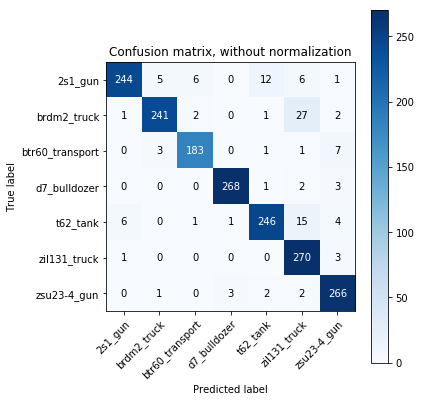

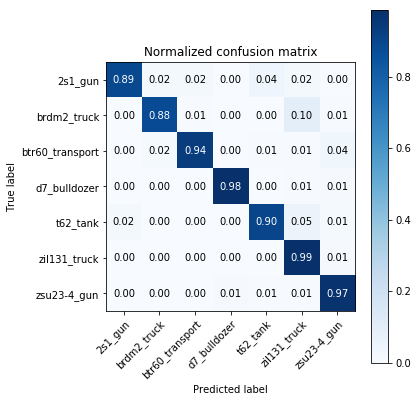

In [2]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
#     classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots(figsize=(6,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# Plot non-normalized confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1), y_pred, classes=label_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(y_test.argmax(axis=1), y_pred, classes=label_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()
plt.close()

[5 4 3 ... 0 0 6]


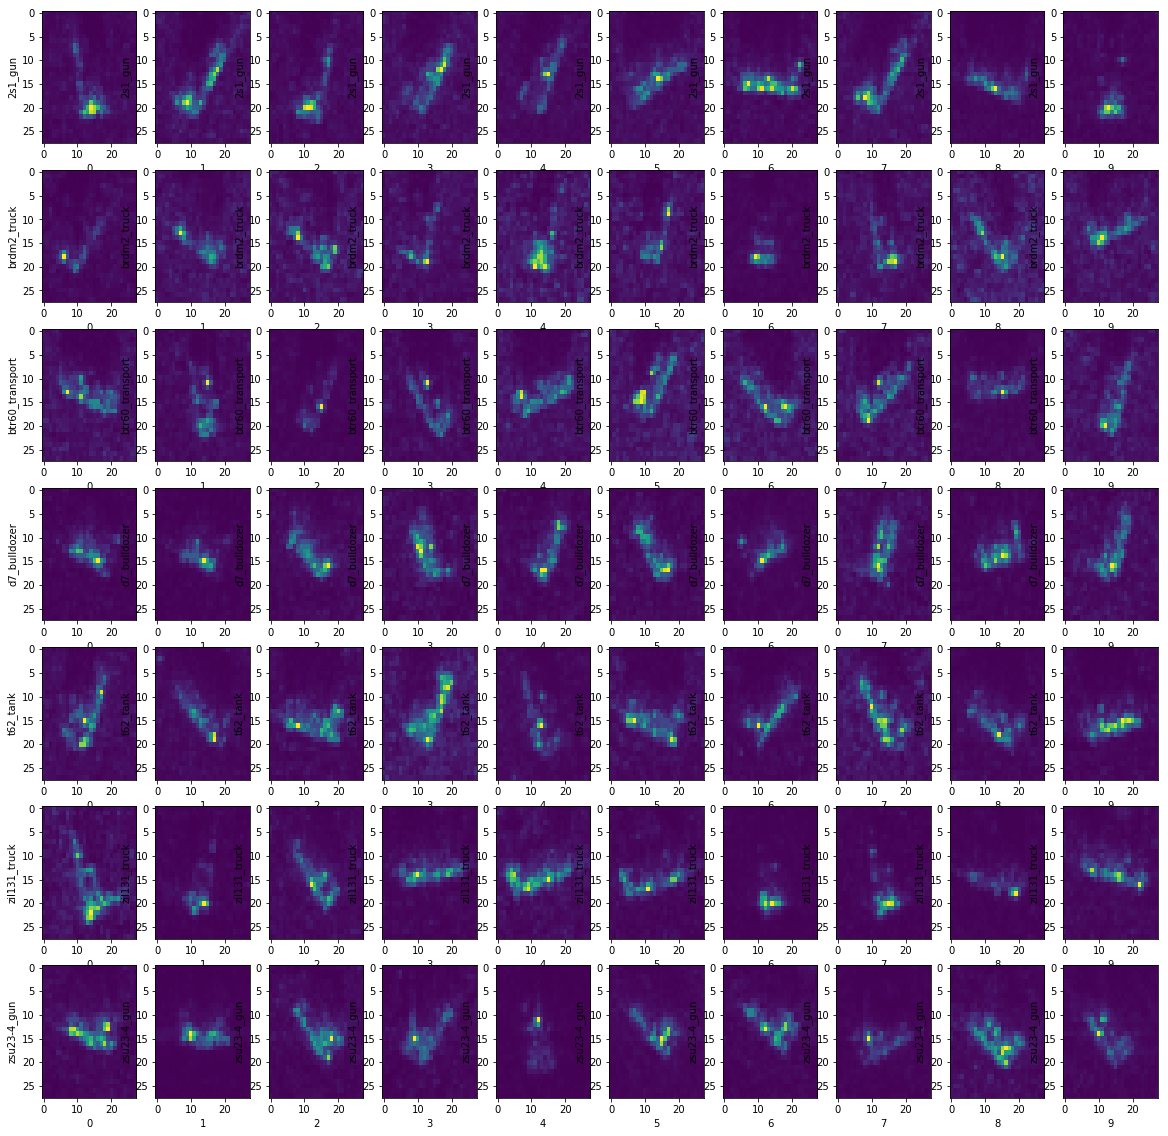

In [3]:
labels1 = y_test.argmax(axis=1)
# x_test1 = TESTING[0]
# print(x_test1[0])
# print(w, h)
# labels1 = TESTING[1]
print(labels1)
fig, ax = plt.subplots(numlabels, 10, figsize=(20, 20))
idd = [0 for xx in range(10)]
for i in range(num_test_samples):
    if sum(idd)>(10*10):
        break
    if idd[labels1[i]] >= 10:
        continue
            
#     print("lab", labels[i])
#     print("idx", idd[labels[i]])
    ax[labels1[i], idd[labels1[i]]].imshow(np.reshape(x_test[i], (w, h)))
#             fig.colorbar(im, ax=ax[i])
            #     plt.colorbar()
    ax[labels1[i], idd[labels1[i]]].set_aspect('auto')
#     ax[labels[i], idd[labels[i]]].axis('off')
            
    idd[labels1[i]] +=1
            
tp = 0
tp1 = 0
for axs in ax.flat:
    axs.set(xlabel=str(tp), ylabel=label_names[tp1])
    
    tp += 1
    if tp%10==0:
        tp1 +=1
        tp = 0
    
plt.show()
plt.close()

In [4]:

numTrainSamples = num_train_samples #num samples per epoch
# numTrainSamples = 2000 #num samples per epoch

numTestSamples = num_test_samples # num of test samples
phase_length = 64 # phase length (always power of 2)
ver_period = 1 # verification/testing after ver_period epochs
# Define the parameters using a utility class that sets up the various default parameters
eplParams = ParamemtersForEPL()

#modify only the ones we need. Here we set the seed for the random number generator to 100 so that the results are repeatble.
eplParams.phaseLength = phase_length
eplParams.useRandomSeed=False
eplParams.randomGenSeed=100
eplParams.numTrainingSamples = numTrainSamples
eplParams.numTestingSamples = numTestSamples
# list the various parameters
eplParams.showDefaults()

load_flag = 0
save_flag = 1
pth = '/homes/amarshrestha/projects/test2/EMSTDP/' # save/load path for the model weights
load_ep = str(1)
wgtname = 'EMSTDP_MSTAR7_ver3_conv_ep' + load_ep + '.npy'


numlayers=2
numInputs=784
numHidNurns=[100, 7]
numTargets=7
phaseLength=64
connProbMCToGC=0.2
useRandomSeed=False
randomGenSeed=100
numTrainingSamples=4200
numTestingSamples=1838
numGammaCyclesTrain=45
numGammaCyclesTest=5
numGammaCyclesIdle=5
useLMTSpikeCounters=False
logSNIPs=False
executionTimeProbe=True


Starting epoch:  0
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 28.45052 secs


/homes/amarshrestha/venv9/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


['2s1_gun', 'brdm2_truck', 'btr60_transport', 'd7_bulldozer', 't62_tank', 'zil131_truck', 'zsu23-4_gun']
Counter({0: 299, 3: 299, 4: 299, 5: 299, 6: 299, 1: 298, 2: 256})
Counter({0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600})
_genCodeForConstants took 0.03519 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:34903
INFO:DRV:      Host server up..............Done 0.22s
INFO:DRV:      Compiling Embedded snips....Done 0.99s
INFO:DRV:      Encoding axons/synapses.....Done 1.41s
INFO:DRV:      Encoding probes.............Done 0.04s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602839078.3632371/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=1 
INFO:DRV:      Booting up..................Done 2.64s
INFO:DRV:      Transferring spikes.........Done 0.88ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 0.42s
INFO:DRV:      Configurin

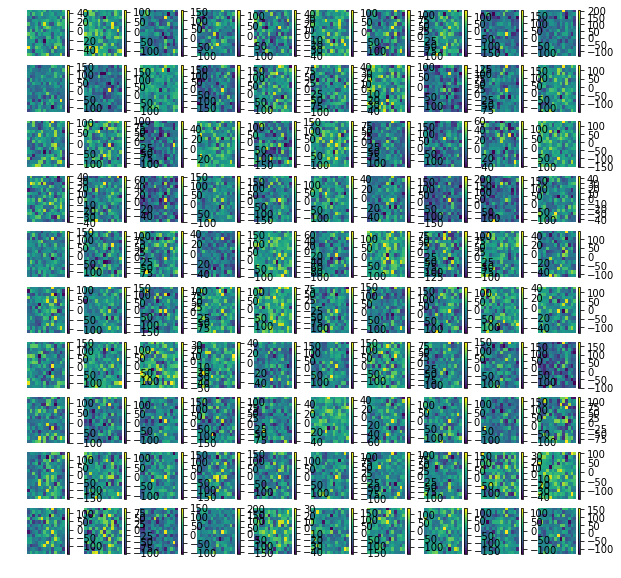

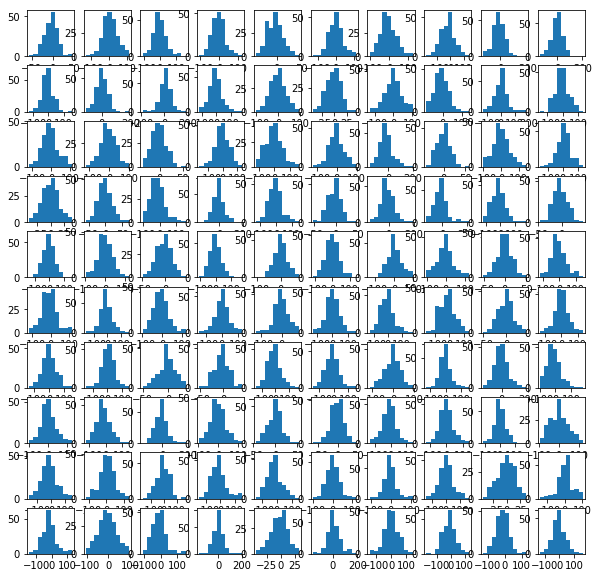

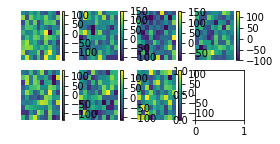

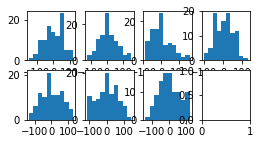

weights saved for epoch_0

conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 28.16972 secs


/homes/amarshrestha/venv9/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


['2s1_gun', 'brdm2_truck', 'btr60_transport', 'd7_bulldozer', 't62_tank', 'zil131_truck', 'zsu23-4_gun']
Counter({0: 299, 3: 299, 4: 299, 5: 299, 6: 299, 1: 298, 2: 256})
Counter({0: 600, 1: 600, 2: 600, 3: 600, 4: 600, 5: 600, 6: 600})
_genCodeForConstants took 0.03693 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:38199
INFO:DRV:      Host server up..............Done 0.26s
INFO:DRV:      Compiling Embedded snips....Done 1.01s
INFO:DRV:      Encoding axons/synapses.....Done 1.10s
INFO:DRV:      Encoding probes.............Done 0.04s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602839296.3322513/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.55s
INFO:DRV:      Transferring spikes.........Done 0.89ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 0.42s
INFO:DRV:      Configurin

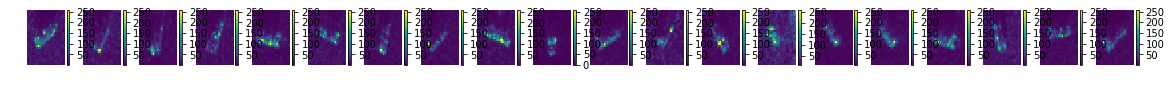

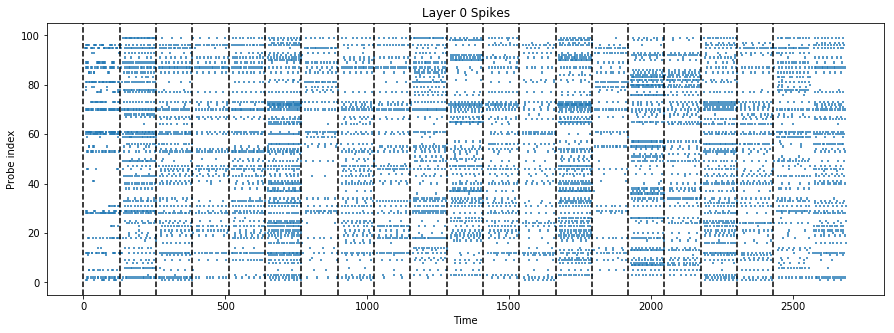

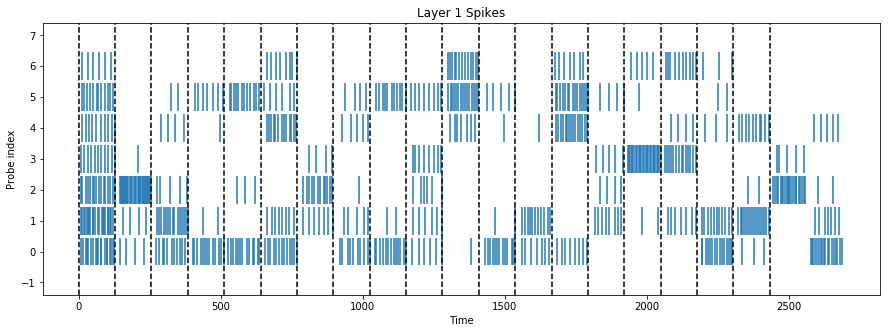

[ 4  4 29  1  0  0  0]
[11 15  5  0  4  2  0]
[13  2  0  0  1  7  0]
[13  0  3  0  0 12  0]
[13  8  0  0 13  6  8]
[ 0  7 12  4  0  0  0]
[10  5  1  0  5  4  0]
[13  2  0  0  0 11  0]
[6 6 6 8 0 8 0]
[ 1  0  0  0  7 15 13]
[13  2  0  0  1  5  0]
[ 7 11  0  0  1  0  0]
[ 8  0  0  0 15 15  7]
[0 8 4 5 0 4 0]
[ 0  2  0 25  0  1  5]
[ 0  7  0 14  4  0 10]
[15 11  0  0  3  2  3]
[ 3 16  2  0 10  0  0]
[ 0  0 21  5  0  0  0]
[18  7  2  0  5  0  0]
[2 1 5 0 4 1 2 1 5 5 0 1 5 2 3 3 4 2 2 0]
[2 1 0 0 4 2 0 0 5 5 0 1 5 1 3 3 0 1 2 0]
[1 1 0 1 1 0 0 0 1 1 1 1 1 0 1 1 0 0 1 1]
65.0
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 28.26304 secs
_genCodeForConstants took 0.04012 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:39777
INFO:DRV:      Host server up..............Done 0.23s
INFO:DRV:      Encoding axons/

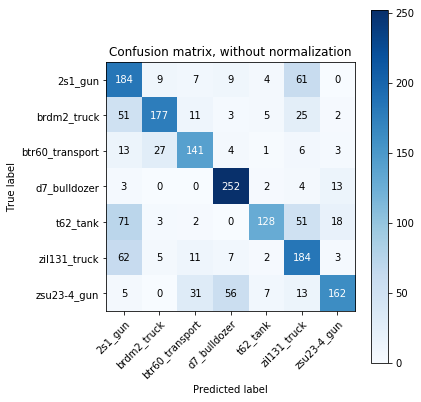

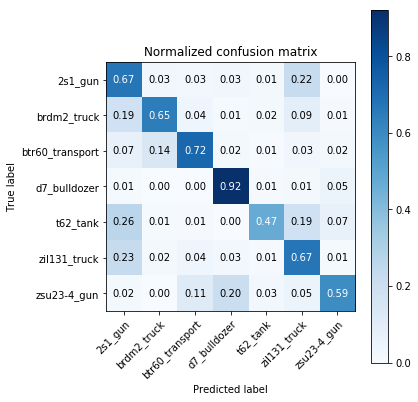

Starting epoch:  2
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 29.09033 secs
_genCodeForConstants took 0.03985 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:46059
INFO:DRV:      Host server up..............Done 0.26s
INFO:DRV:      Compiling Embedded snips....Done 1.04s
INFO:DRV:      Encoding axons/synapses.....Done 1.14s
INFO:DRV:      Encoding probes.............Done 0.04s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602839489.2762675/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=1 
INFO:DRV:      Booting up..................Done 2.55s
INFO:DRV:      Transferring spikes.........Done 0.89ms
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 0.37s
INFO:DRV:      Configuring regis

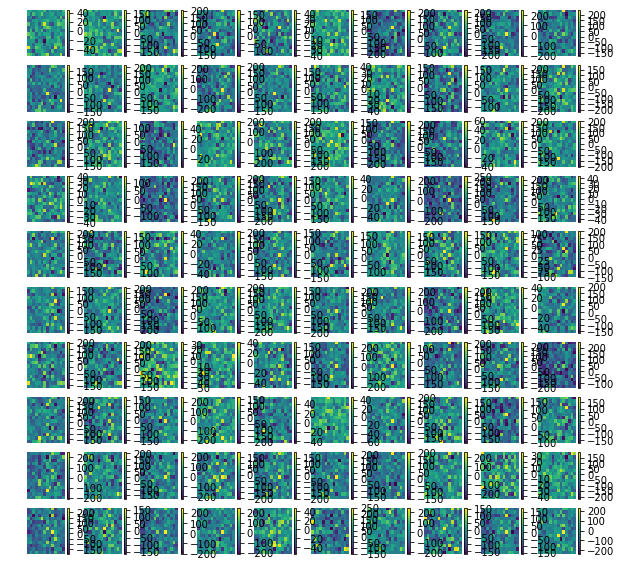

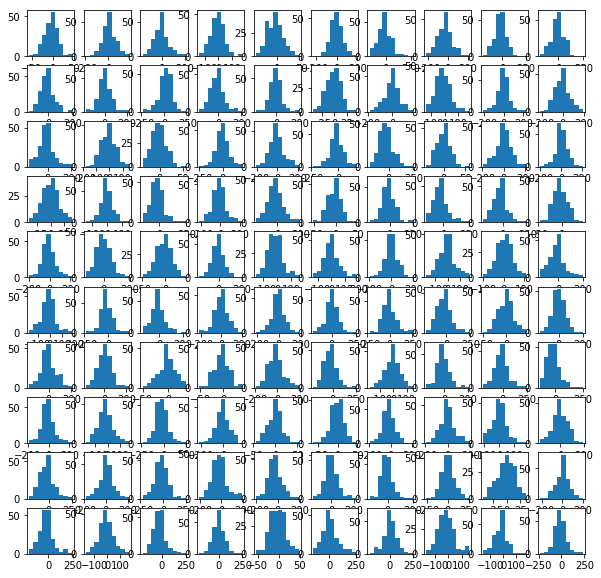

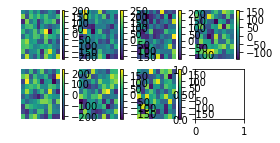

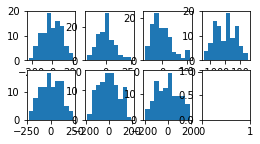

weights saved for epoch_1

conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 30.44662 secs
_genCodeForConstants took 0.03684 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:46421
INFO:DRV:      Host server up..............Done 0.27s
INFO:DRV:      Compiling Embedded snips....Done 1.12s
INFO:DRV:      Encoding axons/synapses.....Done 1.12s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602839697.3719857/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.55s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Encoding probes.............Done 0.04s
INFO:DRV:      Configuring registers.......Done 0.30s
INFO:DRV:      Transferring probes.........Done 0.43s
INFO:DRV:      Transferri

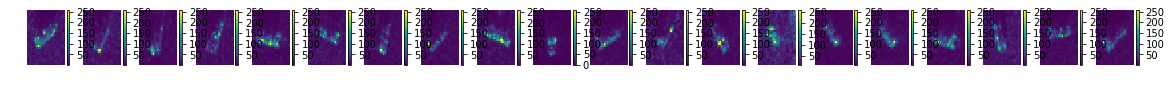

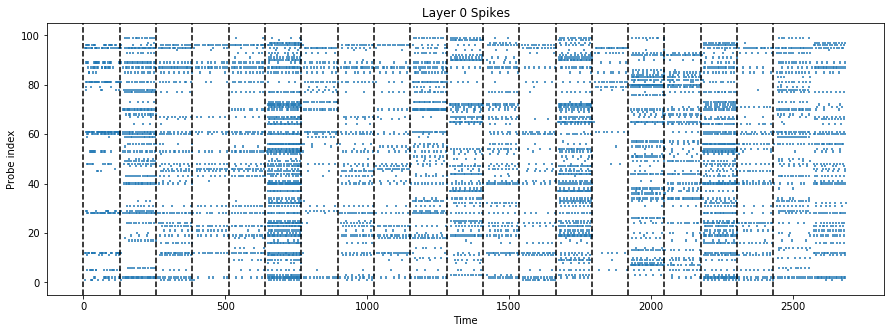

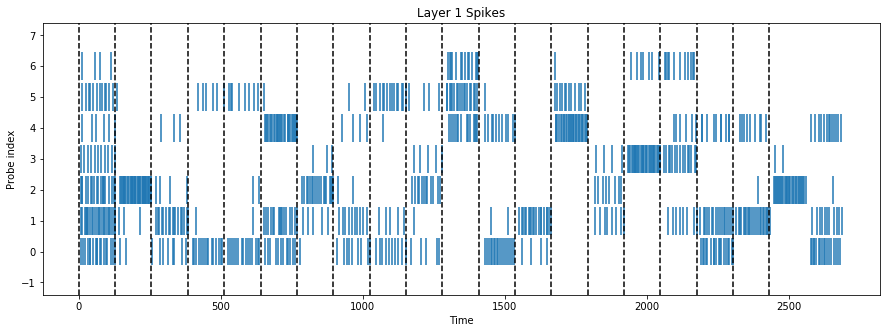

[ 3  3 37  0  0  1  0]
[ 7 17  4  0  3  0  0]
[15  1  0  0  0  6  0]
[15  1  2  0  0  8  0]
[12 16  0  0 28  1  0]
[ 1  5 18  3  0  0  0]
[ 9 10  2  0  4  2  0]
[10  5  0  0  1 14  0]
[ 5  1 12  5  0  4  0]
[ 0  0  0  0 14 18 14]
[17  2  0  0 11  1  0]
[ 4 19  0  0  0  0  0]
[ 0  0  0  0 28 12  1]
[0 8 8 4 0 0 0]
[ 0  0  0 32  0  0  7]
[ 0  8  0 15  6  0 11]
[18 17  0  0 10  0  0]
[ 0 22  1  0  9  0  0]
[ 0  0 30  2  0  0  0]
[17 11  1  0 13  0  0]
[2 1 5 0 4 1 2 1 5 5 0 1 5 2 3 3 4 2 2 0]
[2 1 0 0 4 2 1 5 2 5 0 1 4 2 3 3 0 1 2 0]
[1 1 0 1 1 0 0 0 0 1 1 1 0 1 1 1 0 0 1 1]
60.0
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 27.53914 secs
_genCodeForConstants took 0.03478 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:38213
INFO:DRV:      Host server up..............Done 0.24s
INFO:DRV:      Compilin

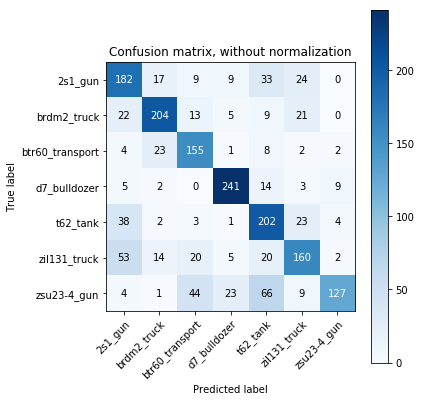

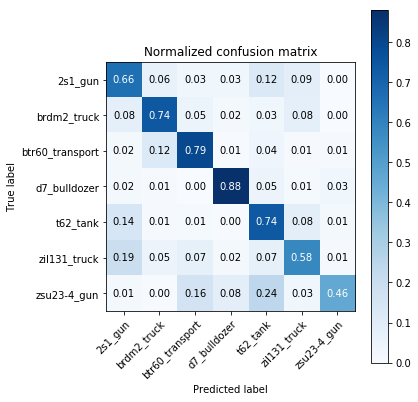

Starting epoch:  4
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 28.34259 secs
_genCodeForConstants took 0.03478 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:42531
INFO:DRV:      Host server up..............Done 0.27s
INFO:DRV:      Encoding axons/synapses.....Done 1.13s
INFO:DRV:      Compiling Embedded snips....Done 1.20s
INFO:DRV:      Encoding probes.............Done 2.10s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602839892.1538796/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=1 
INFO:DRV:      Booting up..................Done 2.64s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 0.41s
INFO:DRV:      Configuring registers.......Done 0.44s
INFO:DRV:      Transferring spike

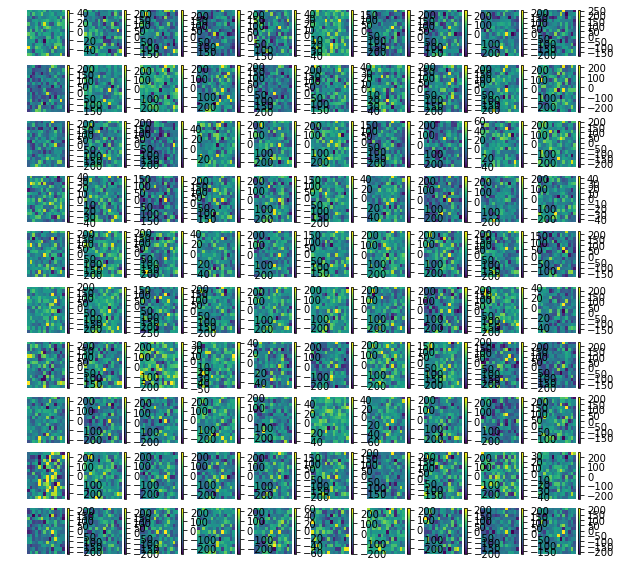

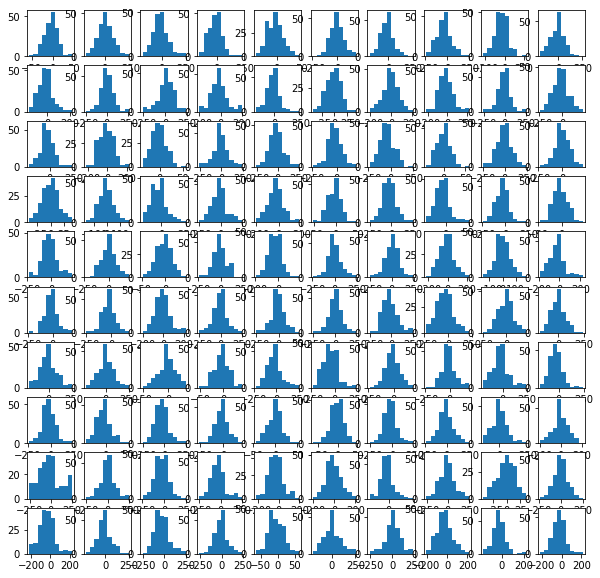

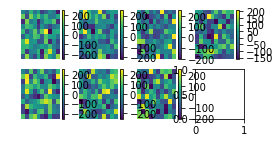

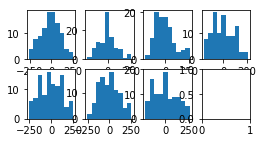

weights saved for epoch_2

conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 28.28155 secs
_genCodeForConstants took 0.03548 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:37379
INFO:DRV:      Host server up..............Done 0.29s
INFO:DRV:      Compiling Embedded snips....Done 1.19s
INFO:DRV:      Encoding axons/synapses.....Done 1.11s
INFO:DRV:      Encoding probes.............Done 0.04s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602840099.590625/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.64s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 0.38s
INFO:DRV:      Transferring spikes.........Done 0.79ms
INFO:DRV:      Configurin

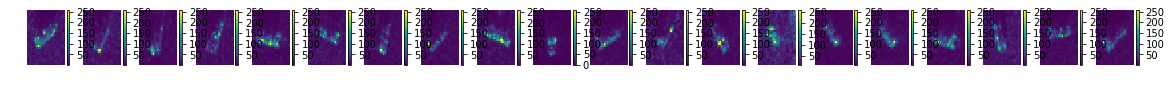

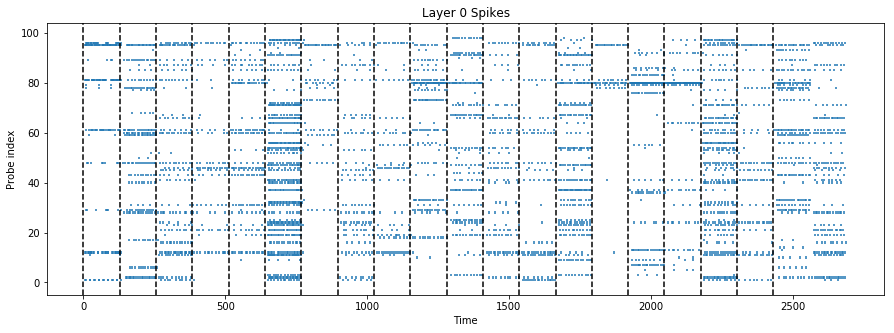

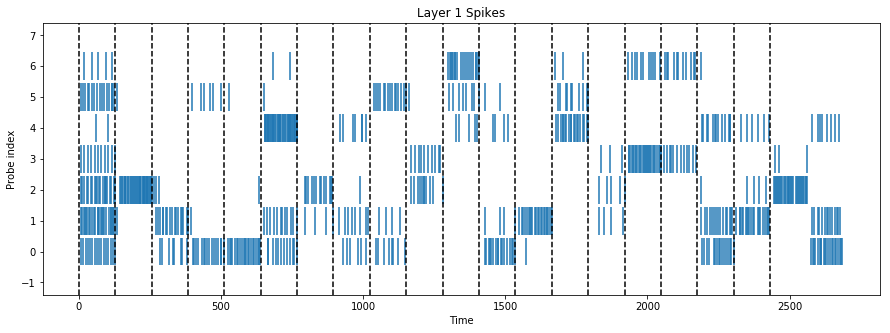

[ 0  1 37  0  0  1  0]
[ 8 17  3  0  0  0  0]
[16  1  0  0  0  6  0]
[21  0  1  0  0  1  0]
[12 12  0  0 40  1  2]
[ 0  4 13  0  0  0  0]
[6 8 1 0 7 0 0]
[ 8  4  0  0  0 15  0]
[ 0  0 11 10  0  1  0]
[ 0  0  0  0  5  8 19]
[17  4  0  0  4  2  0]
[ 1 22  0  0  0  0  0]
[ 0  0  0  0 19 10  3]
[0 4 5 3 0 0 0]
[ 0  0  0 28  0  0 11]
[ 0  0  0 12  0  0 11]
[16 15  1  0 13  0  1]
[ 0 20  4  0  6  0  0]
[ 0  0 31  3  0  0  0]
[21 14  0  0  8  0  0]
[2 1 5 0 4 1 2 1 5 5 0 1 5 2 3 3 4 2 2 0]
[2 1 0 0 4 2 1 5 2 6 0 1 4 2 3 3 0 1 2 0]
[1 1 0 1 1 0 0 0 0 0 1 1 0 1 1 1 0 0 1 1]
55.00000000000001
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 27.69568 secs
_genCodeForConstants took 0.05450 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:36577
INFO:DRV:      Host server up..............Done 0.30s
INFO:DRV:      Co

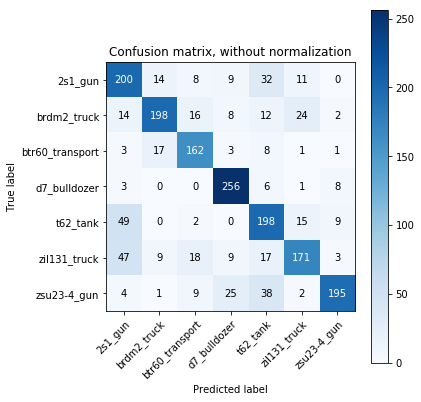

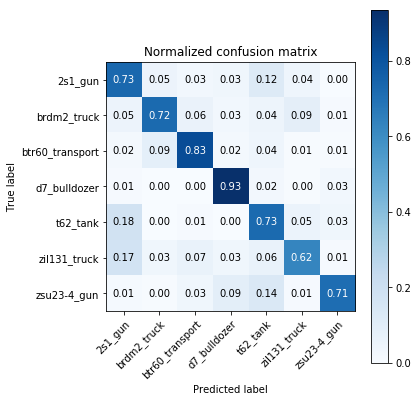

Starting epoch:  6
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 29.18740 secs
_genCodeForConstants took 0.07679 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:42381
INFO:DRV:      Host server up..............Done 0.34s
INFO:DRV:      Encoding axons/synapses.....Done 1.12s
INFO:DRV:      Compiling Embedded snips....Done 1.24s
INFO:DRV:      Encoding probes.............Done 0.04s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602840294.4883006/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=1 
INFO:DRV:      Booting up..................Done 2.55s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Configuring registers.......Done 0.33s
INFO:DRV:      Transferring probes.........Done 0.37s
INFO:DRV:      Transferring spike

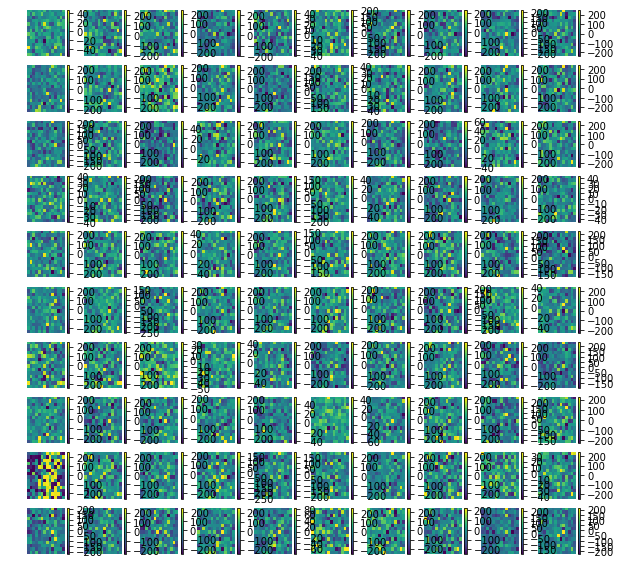

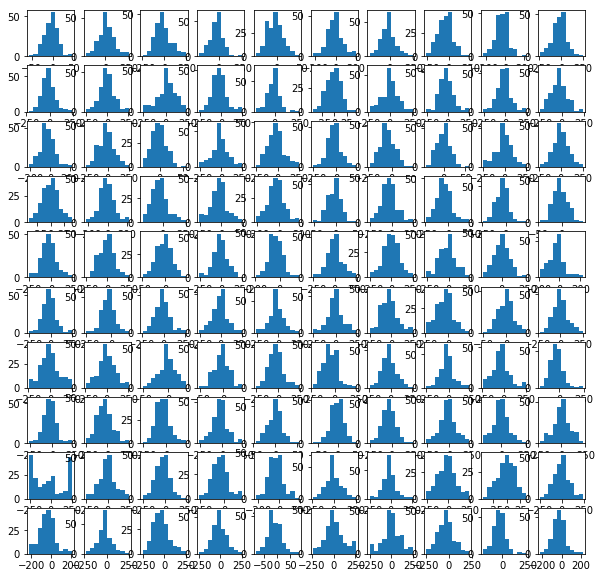

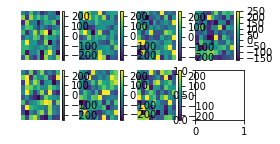

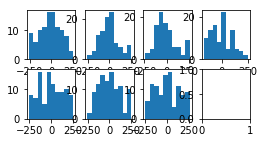

weights saved for epoch_3

conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 28.72094 secs
_genCodeForConstants took 0.03615 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:34959
INFO:DRV:      Host server up..............Done 0.32s
INFO:DRV:      Compiling Embedded snips....Done 1.22s
INFO:DRV:      Encoding axons/synapses.....Done 1.12s
INFO:DRV:      Encoding probes.............Done 0.04s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602840504.396014/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.64s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Configuring registers.......Done 0.30s
INFO:DRV:      Transferring probes.........Done 0.37s
INFO:DRV:      Transferrin

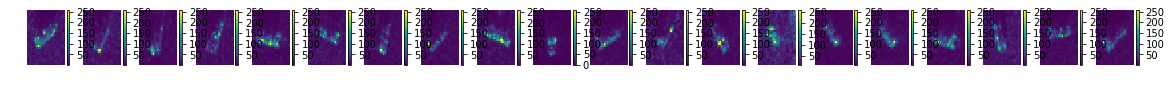

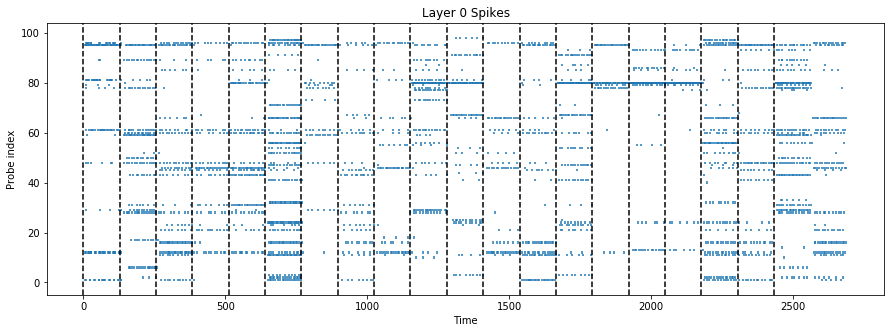

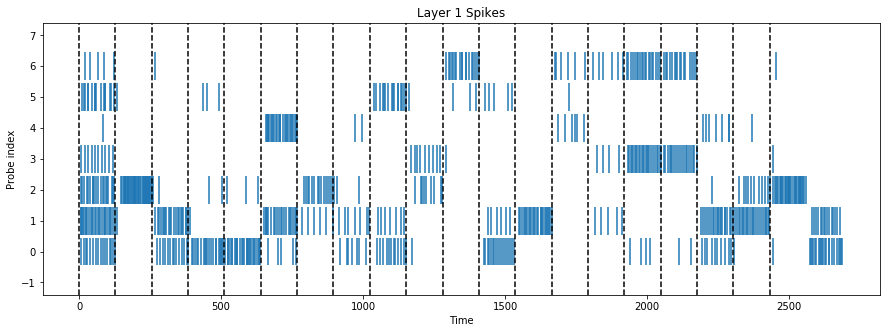

[ 0  1 39  0  0  1  0]
[14 21  2  0  0  0  1]
[21  1  2  0  0  3  0]
[26  0  3  0  0  0  0]
[ 5 21  0  0 27  0  0]
[ 0  6 15  0  0  0  0]
[7 7 2 0 2 0 0]
[12  7  0  0  0 16  0]
[1 0 9 9 0 1 0]
[ 0  0  0  1  0  3 18]
[17  6  0  0  0  5  0]
[ 0 26  0  0  0  0  0]
[0 0 0 0 6 1 6]
[0 5 0 4 0 0 6]
[ 4  0  0 24  0  0 19]
[ 2  0  0 19  0  0 16]
[11 20  1  0  7  0  0]
[ 0 23 11  0  1  0  0]
[ 1  0 33  1  0  0  1]
[22 15  0  0  0  0  0]
[2 1 5 0 4 1 2 1 5 5 0 1 5 2 3 3 4 2 2 0]
[2 1 0 0 4 2 0 5 2 6 0 1 4 6 3 3 1 1 2 0]
[1 1 0 1 1 0 0 0 0 0 1 1 0 0 1 1 0 0 1 1]
50.0
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 27.40482 secs
_genCodeForConstants took 0.03467 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:33771
INFO:DRV:      Host server up..............Done 0.28s
INFO:DRV:      Compiling Embedded snips....D

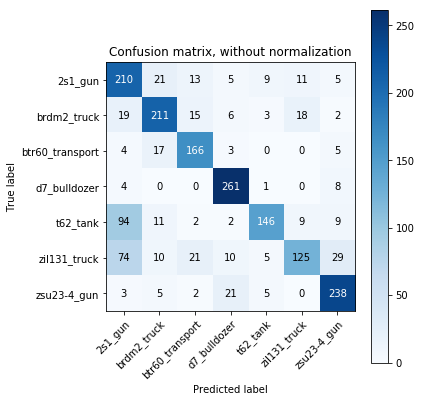

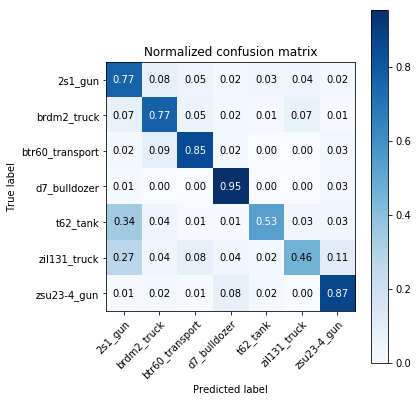

Starting epoch:  8
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 28.78455 secs
_genCodeForConstants took 0.03478 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:33987
INFO:DRV:      Host server up..............Done 0.32s
INFO:DRV:      Encoding axons/synapses.....Done 1.12s
INFO:DRV:      Compiling Embedded snips....Done 1.22s
INFO:DRV:      Encoding probes.............Done 0.04s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602840708.7811162/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=1 
INFO:DRV:      Booting up..................Done 2.64s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 0.37s
INFO:DRV:      Configuring registers.......Done 0.37s
INFO:DRV:      Transferring spike

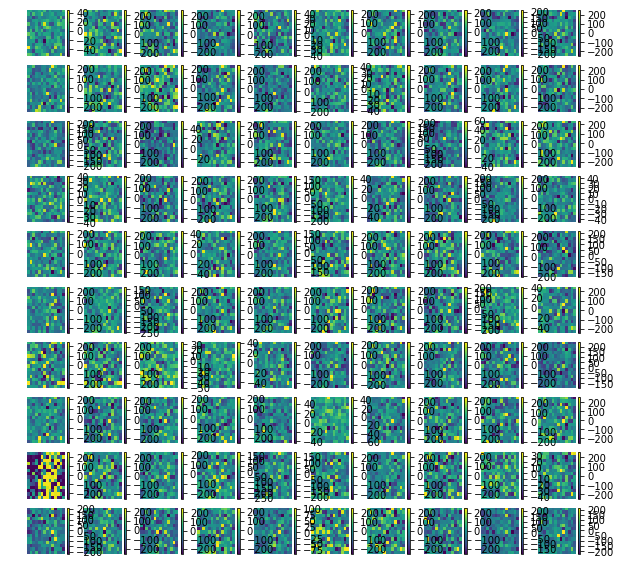

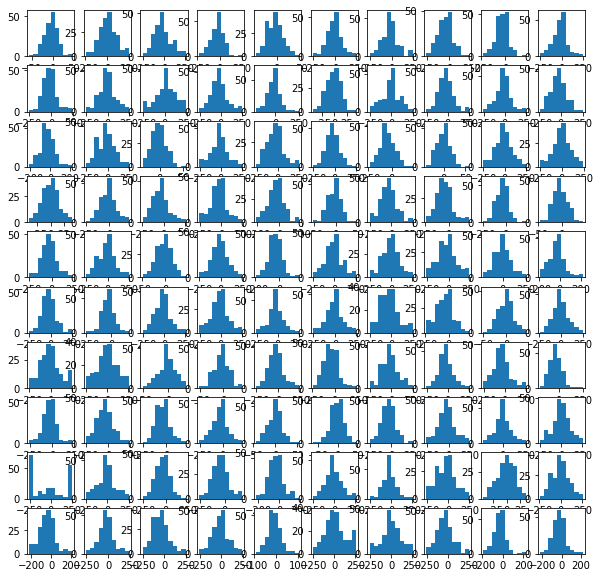

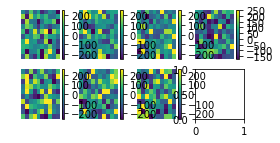

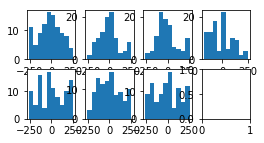

weights saved for epoch_4

conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 29.27615 secs
_genCodeForConstants took 0.03801 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:38017
INFO:DRV:      Host server up..............Done 0.39s
INFO:DRV:      Compiling Embedded snips....Done 1.65s
INFO:DRV:      Encoding axons/synapses.....Done 2.38s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602840919.2118592/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.56s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Encoding probes.............Done 0.07s
INFO:DRV:      Transferring spikes.........Done 3.63ms
INFO:DRV:      Configuring registers.......Done 0.48s
INFO:DRV:      Transferr

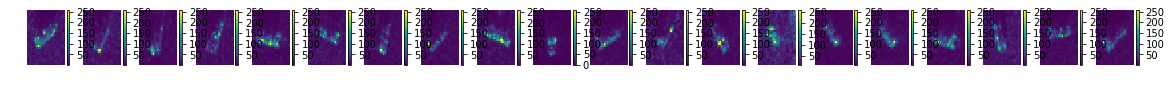

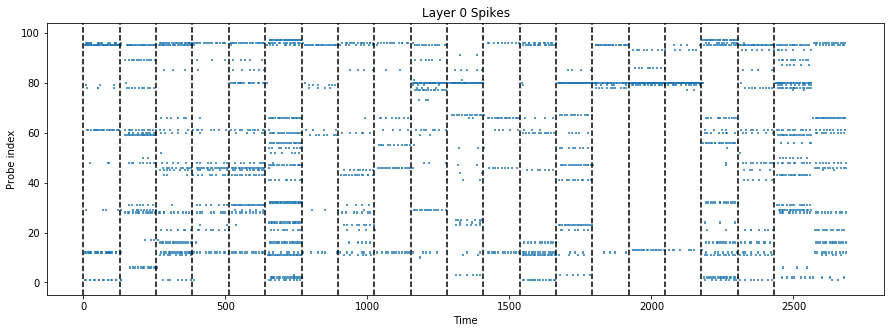

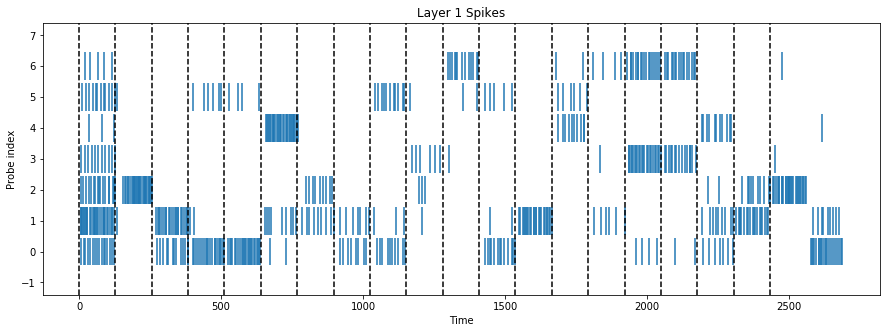

[ 0  1 29  0  0  1  0]
[13 22  0  0  0  0  0]
[20  2  0  0  0  6  0]
[24  0  0  0  0  4  0]
[ 2  9  0  0 31  0  0]
[0 9 9 0 0 0 0]
[8 7 0 0 0 0 0]
[10  3  0  0  0 11  0]
[0 1 3 6 0 1 0]
[ 0  0  0  1  0  2 13]
[13  2  0  0  0  5  0]
[ 0 24  0  0  0  0  0]
[ 0  0  0  0 10  6  2]
[0 6 0 1 0 0 4]
[ 4  0  0 23  0  0 18]
[ 2  0  0 15  0  0 16]
[ 7  9  2  0 11  0  0]
[ 0 19 10  0  0  0  0]
[ 0  0 29  1  0  0  1]
[21  9  0  0  1  0  0]
[2 1 5 0 4 1 2 1 5 5 0 1 5 2 3 3 4 2 2 0]
[2 1 0 0 4 1 0 5 3 6 0 1 4 1 3 6 4 1 2 0]
[1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1 0 1 1]
55.00000000000001
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 27.68599 secs
_genCodeForConstants took 0.13734 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.110:43097
INFO:DRV:      Host server up..............Done 0.32s
INFO:DRV:      Compiling Embedd

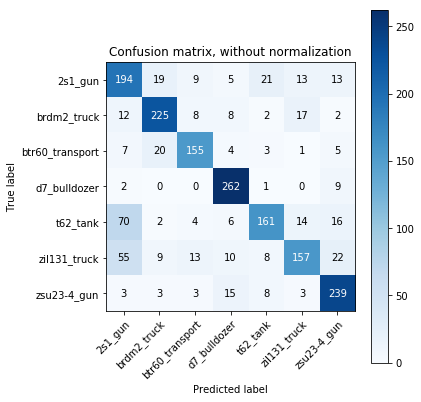

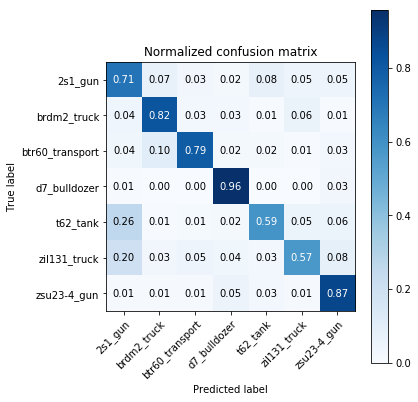

Starting epoch:  10
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 28.27134 secs
_genCodeForConstants took 0.03483 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:41933
INFO:DRV:      Host server up..............Done 0.34s
INFO:DRV:      Compiling Embedded snips....Done 1.27s
INFO:DRV:      Encoding axons/synapses.....Done 1.12s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602841119.2568817/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=1 
INFO:DRV:      Booting up..................Done 2.64s
INFO:DRV:      Encoding probes.............Done 0.04s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring spikes.........Done 2.68ms
INFO:DRV:      Transferring probes.........Done 0.37s
INFO:DRV:      Configuring regi

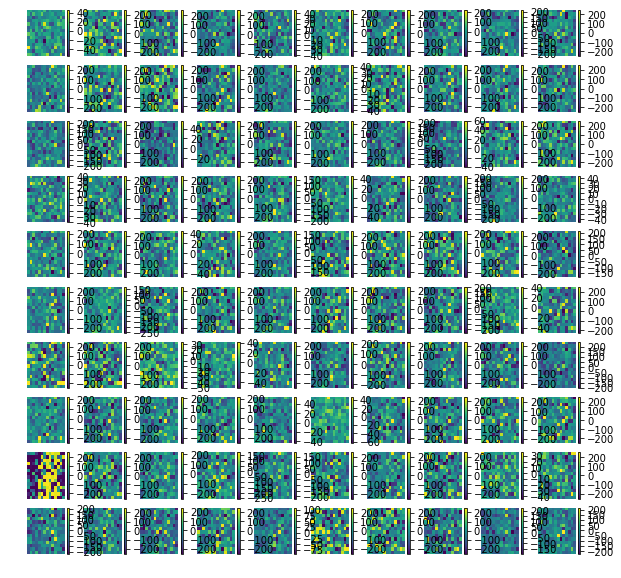

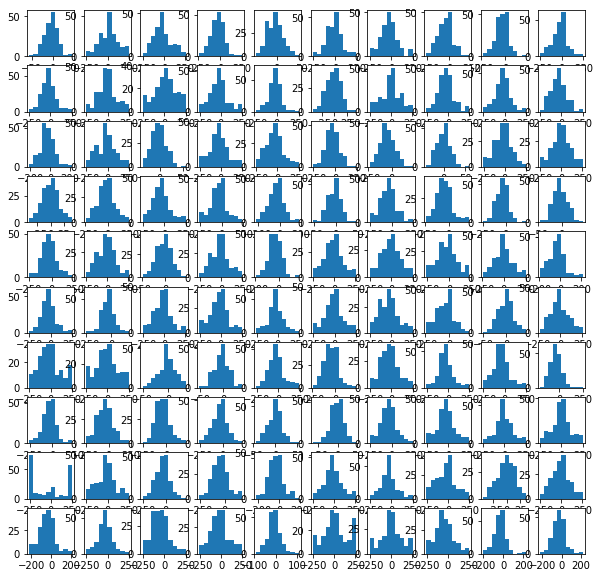

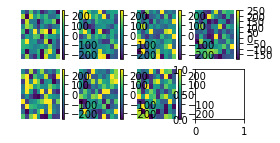

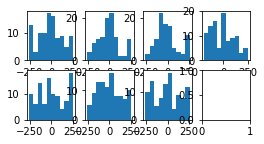

weights saved for epoch_5

conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 27.48698 secs
_genCodeForConstants took 0.04086 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:32785
INFO:DRV:      Host server up..............Done 0.35s
INFO:DRV:      Encoding axons/synapses.....Done 1.10s
INFO:DRV:      Compiling Embedded snips....Done 1.28s
INFO:DRV:      Encoding probes.............Done 0.04s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602841327.2964213/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.64s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Configuring registers.......Done 0.30s
INFO:DRV:      Transferring spikes.........Done 3.33ms
INFO:DRV:      Transferr

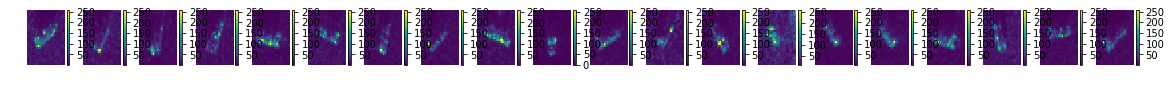

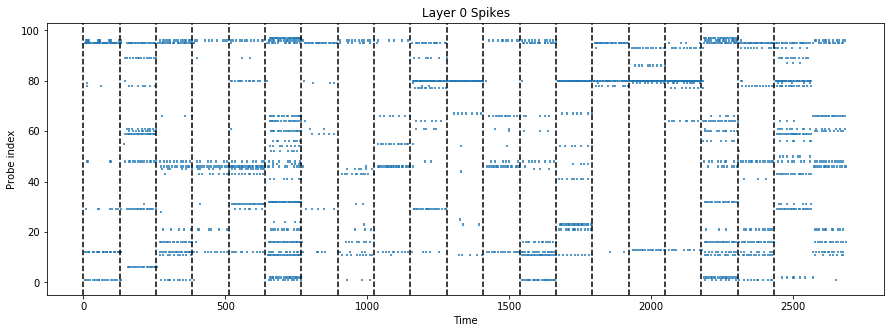

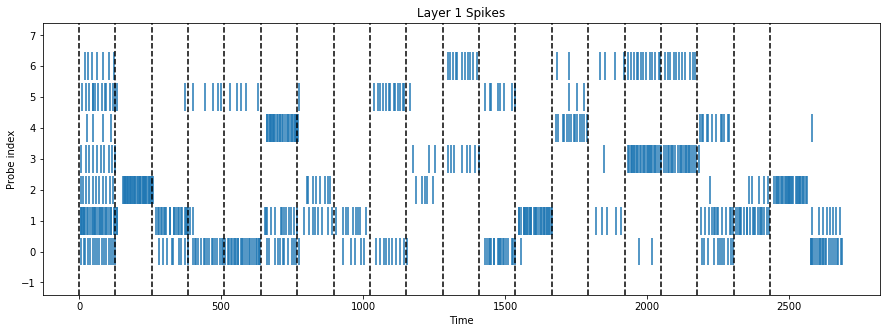

[ 0  2 34  0  0  1  0]
[ 9 21  1  0  0  1  0]
[17  2  0  0  0  5  0]
[23  0  0  0  0  5  0]
[11 13  0  0 28  0  0]
[1 8 8 0 0 1 0]
[5 9 0 0 0 0 0]
[10  0  0  0  0 13  0]
[0 0 5 3 0 1 0]
[ 0  0  0  8  0  0 11]
[18  0  0  0  0  8  0]
[ 1 30  0  0  0  0  0]
[ 0  0  0  0 14  3  2]
[0 5 0 1 0 0 4]
[ 2  0  0 27  0  0 13]
[ 0  0  0 21  0  0 11]
[11 13  1  1 12  0  0]
[ 0 19  5  0  0  0  0]
[ 0  0 29  0  0  0  0]
[21  8  0  0  1  0  0]
[2 1 5 0 4 1 2 1 5 5 0 1 5 2 3 3 4 2 2 0]
[2 1 0 0 4 1 1 5 2 6 0 1 4 1 3 3 1 1 2 0]
[1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1]
55.00000000000001
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 28.35003 secs
_genCodeForConstants took 0.04518 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.108:40981
INFO:DRV:      Host server up..............Done 0.31s
INFO:DRV:      Encoding axons/s

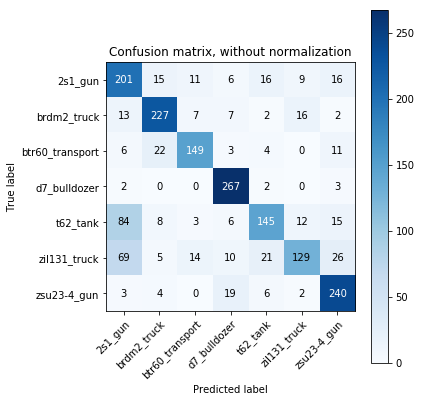

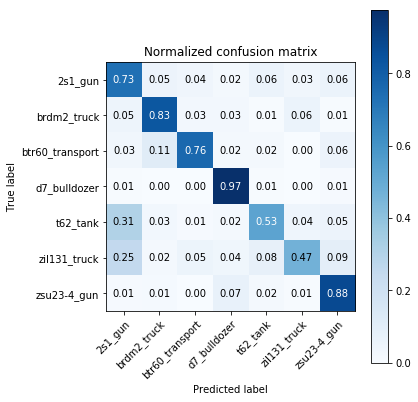

Starting epoch:  12
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 29.70157 secs
_genCodeForConstants took 0.03671 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:40321
INFO:DRV:      Host server up..............Done 0.33s
INFO:DRV:      Encoding axons/synapses.....Done 1.15s
INFO:DRV:      Compiling Embedded snips....Done 1.40s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602841527.33171/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=1 
INFO:DRV:      Booting up..................Done 2.55s
INFO:DRV:      Encoding probes.............Done 0.04s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Transferring probes.........Done 0.38s
INFO:DRV:      Configuring registers.......Done 0.35s
INFO:DRV:      Transferring spikes

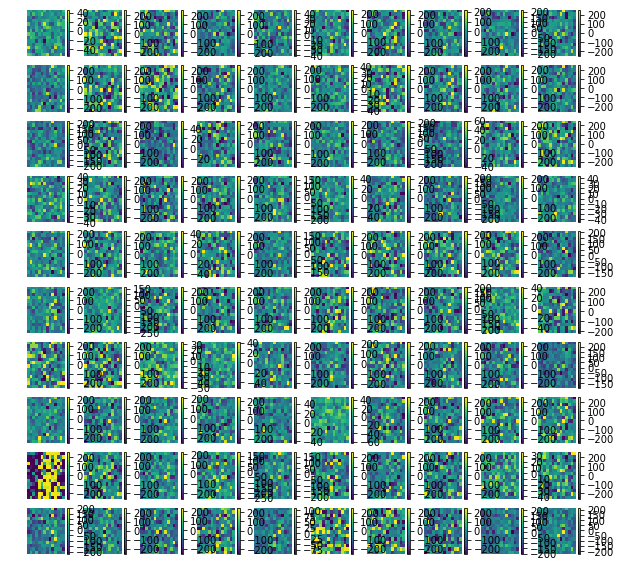

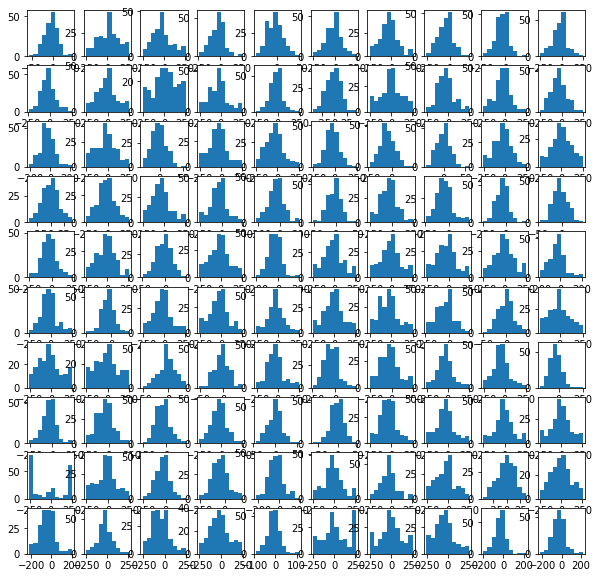

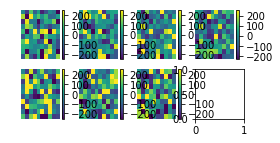

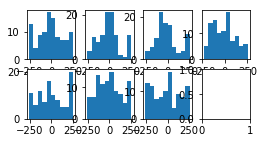

weights saved for epoch_6

conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 27.73092 secs
_genCodeForConstants took 0.03672 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.110:38893
INFO:DRV:      Host server up..............Done 0.37s
INFO:DRV:      Compiling Embedded snips....Done 1.42s
INFO:DRV:      Encoding axons/synapses.....Done 1.14s
INFO:HST:  Args chip=0 cpu=0 /homes/amarshrestha/venv9/lib/python3.5/site-packages/nxsdk/driver/compilers/../../../temp/1602841736.5765202/launcher_chip0_lmt0.bin --chips=1 --remote-relay=1 --epoch=0 
INFO:DRV:      Booting up..................Done 2.63s
INFO:HST:  Lakemont_driver...
INFO:DRV:      Encoding probes.............Done 0.04s
INFO:DRV:      Transferring spikes.........Done 0.81ms
INFO:DRV:      Configuring registers.......Done 0.31s
INFO:DRV:      Transferr

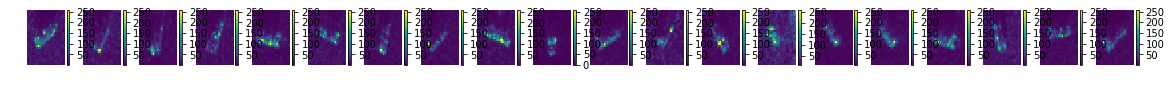

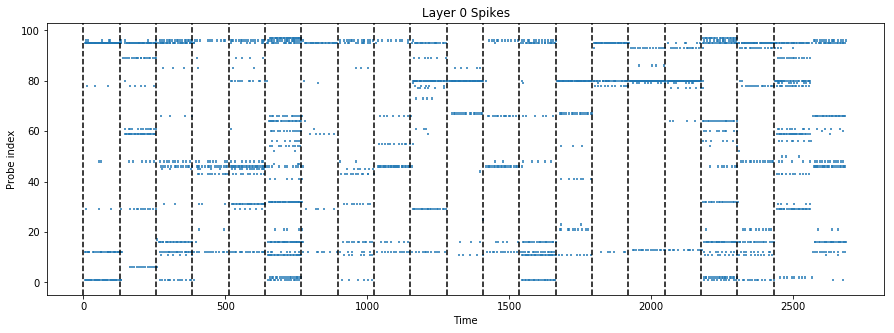

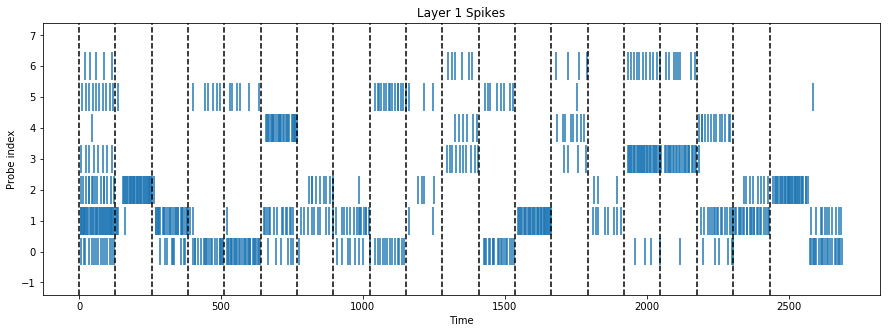

[ 0  3 32  0  0  1  0]
[ 9 27  1  0  0  0  0]
[19  2  0  0  0  6  0]
[27  1  0  0  0  6  0]
[ 6 14  0  0 27  0  0]
[ 1 10  9  0  0  0  0]
[ 8 14  1  0  0  0  0]
[13  0  0  0  0 15  0]
[0 2 4 0 0 3 0]
[ 0  0  0 10  6  0  6]
[18  0  0  0  0  8  0]
[ 0 33  0  0  0  0  0]
[0 0 0 4 8 1 4]
[0 8 3 0 0 0 0]
[ 4  0  0 31  0  0 11]
[ 1  0  0 23  0  0  8]
[ 6 16  0  1 13  0  0]
[ 0 22  8  0  0  0  0]
[ 0  0 32  0  0  0  0]
[21 11  1  0  0  1  0]
[2 1 5 0 4 1 2 1 5 5 0 1 5 2 3 3 4 2 2 0]
[2 1 0 0 4 1 1 5 2 3 0 1 4 1 3 3 1 1 2 0]
[1 1 0 1 1 1 0 0 0 0 1 1 0 0 1 1 0 0 1 1]
55.00000000000001
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662
compileAndGetBoard took 27.15789 secs
_genCodeForConstants took 0.05601 secs
INFO:DRV:  SLURM is being run in background
INFO:DRV:  Connecting to 10.212.98.106:36133
INFO:DRV:      Host server up..............Done 0.35s
INFO:DRV:      Compiling

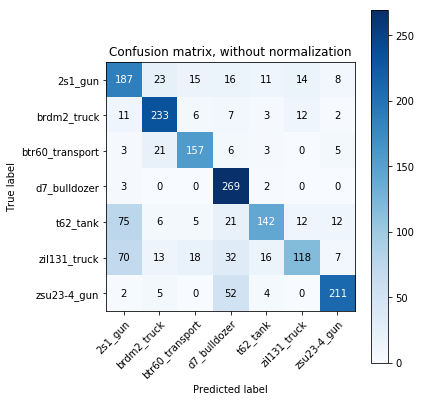

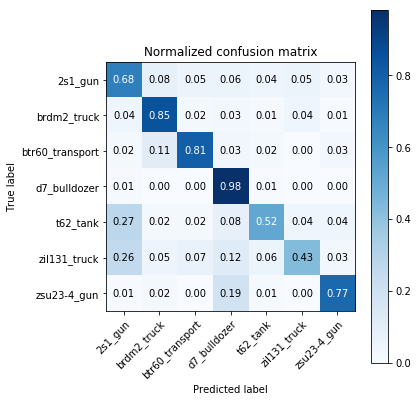

Starting epoch:  14
conv_layer_ 0
dimX 5 dimY 5 dimC 16 stride 2 vth 552
conv_layer_ 1
dimX 3 dimY 3 dimC 8 stride 2 vth 1325
ethreshold = 
8
threshold = 
1561
ethreshold = 
8
threshold = 
662


KeyboardInterrupt: 

In [5]:
%matplotlib inline

def drawIntervalSeperators(intervalBoundaries):
    for t in intervalBoundaries:
        plt.axvline(x=t, color='k', linestyle='--')
        
w = int(np.sqrt(eplParams.numInputs))
h = int(np.sqrt(eplParams.numInputs))

train = True
wgt = []
bwgt = []
total_eps = 20
epochs = 2
# atatime = 10000
disTestSamples = 20

x = []
y1 = []
y2 = []

if load_flag:
    wgt = list(np.load(pth + wgtname, allow_pickle=True))
    print('weights loaded for epoch_' + load_ep + '\n')

for iii in range(0, total_eps, 1):
    
    
    train = True
    atatime = numTrainSamples # breaks runs on loihi into 'atatime' chunks of training set
    
#     train = True
#     atatime = 5
    
    print('Starting epoch: ', iii*epochs)
    trwts = []
    # We now setup an EPL network to learn and recall patterns based on the parameters we set
    epl = EMSTDP(eplParams=eplParams, train=train, conv_wgt=parameters_int, wgt=wgt, bwgt=bwgt)

    if iii==0:
        x, label_names = epl.genTrainingData(numTrainSamples, datset="mstar7")

#         y = epl.genTestingData(numTestSamples)

    epl.fit(trainingSet=x, epochs=epochs, atatime=atatime)
    
    
    # extract hidden layer weights and display
    for jj in range(len(eplParams.numHidNurns)-1):

        layer1num = eplParams.numHidNurns[jj]
        layer = jj
#         r = int(np.ceil(np.sqrt(layer1num)))
#         c = int(np.ceil(np.sqrt(layer1num)))
        r = 10
        c = int(np.ceil(layer1num/r))
        layerin = 0
        if layer == 0:
            w = int(np.floor(np.sqrt(epl.convNumInputs)))
            h = int(np.floor(np.sqrt(epl.convNumInputs)))
            layerin = epl.convNumInputs
        else:
            w = int(np.floor(np.sqrt(eplParams.numHidNurns[jj-1])))
            h = int(np.floor(np.sqrt(eplParams.numHidNurns[jj-1])))
            layerin = eplParams.numHidNurns[jj-1]
                
        fig, ax = plt.subplots(r, c, figsize=(c, r))
        fig1, ax1 = plt.subplots(r, c, figsize=(c, r))
        idx = 0
        hi = 0
        ci = 0
        ldwts = np.zeros((layer1num, layerin))
        for i in range(layer1num):
        #     fig1 = plt.figure(1, figsize=(15, 5))
            wt = np.zeros(layerin)
            k = 0
            for j in range(idx, idx+layerin):
                wt[k] = epl.forwardConnsProbes[layer][j][0].data[-1]
                k = k + 1

    #         wt = (wt - np.min(wt))/(np.max(wt) - np.min(wt))
    #         wt = wt*256 - 128
    #         wt = wt.astype(int)
            ldwts[i] = wt

            im = ax[hi, ci].imshow(np.reshape(wt[0:w*h], (w, h)))
            fig.colorbar(im, ax=ax[hi,ci])
        #     plt.colorbar()
            ax[hi, ci].set_aspect('auto')
            ax[hi, ci].axis('off')
            
            ax1[hi, ci].hist(wt)
            ax1[hi, ci].set_aspect('auto')
#             ax1[hi, ci].axis('off')

            if ci == c-1:
                ci = 0
                hi +=1
            else:
                ci +=1

            idx = idx + layerin
        #     plt.tight_layout()
        # plt.title('Layer 1 Weights')
        # drawIntervalSeperators(list(range(0, epl.numStepsToRun, 2 ** 5)))
        # plt.tight_layout()

        plt.show()
        plt.close()

        trwts.append(ldwts)

    #####################################################################################
    # extract output layer weights and display
    layer = len(eplParams.numHidNurns)-1
    classnum = eplParams.numHidNurns[-1]
    layer1num = eplParams.numHidNurns[-2]
    r = 2
    c = int(np.ceil(classnum/r))

    fig, ax = plt.subplots(r, c, figsize=(c, r))
    fig1, ax1 = plt.subplots(r, c, figsize=(c, r))
    idx = 0
    hi = 0
    ci = 0
    ldwts = np.zeros((classnum, layer1num))
    
    w = int(np.floor((np.sqrt(layer1num))))
    h = int(np.floor((np.sqrt(layer1num))))
    
    for i in range(classnum):
    #     fig1 = plt.figure(1, figsize=(15, 5))
        wt = np.zeros(layer1num)
        k = 0
        for j in range(idx, idx+layer1num):
            wt[k] = epl.forwardConnsProbes[layer][j][0].data[-1]
            k = k + 1

#         wt = (wt - np.min(wt))/(np.max(wt) - np.min(wt))
#         wt = wt*256 - 128
#         wt = wt.astype(int)
        ldwts[i] = wt
        
        im = ax[hi, ci].imshow(np.reshape(wt[0:w*h], (w, h)))
        fig.colorbar(im, ax=ax[hi,ci])
    #     plt.colorbar()
        ax[hi, ci].set_aspect('auto')
        ax[hi, ci].axis('off')
        
        ax1[hi, ci].hist(wt)
        ax1[hi, ci].set_aspect('auto')
#         ax1[hi, ci].axis('off')

        if ci == c-1:
            ci = 0
            hi +=1
        else:
            ci +=1

        idx = idx + layer1num
    #     plt.tight_layout()
    # plt.title('Layer 1 Weights')
    # drawIntervalSeperators(list(range(0, epl.numStepsToRun, 2 ** 5)))
    # plt.tight_layout()

    plt.show()
    plt.close()

    trwts.append(ldwts)

    wgt = trwts
    
    # save all weights as a list of numpy arrays
    save_ep = str(iii)
    wgtname = 'EMSTDP_MSTAR7_ver3_conv_ep' + save_ep + '.npy'
    if save_flag and (iii+1)%ver_period == 0:
        np.save(pth + wgtname, wgt)
        print('weights saved for epoch_' + save_ep + '\n')
    
    bwgt = wgt
    bwgt = [] #dfa=1, # uncomment this for dfa=0 effect (naturally it is not exactly dfa=0 as we are 
                        #replacing backward weights with forward weights every epoch)
        
    del epl
    gc.collect()
    
    # first run a few test samples to see spiking activity of the layers
    # then run the network on the whole test set for results
#     disTestSamples = 20
    #################################################################################
    if numTestSamples > 0 and (iii+1)%ver_period == 0:
        train = False

        # We now setup an EPL network to learn and recall patterns based on the parameters we set
        epl = EMSTDP(eplParams=eplParams, train=train, conv_wgt=parameters_int, wgt=wgt, bwgt=bwgt)

        #generate synthetic training data for 1 pattern
#         x = epl.genTrainingData(numTrainSamples)
        if iii==0:
            y2, label_names = epl.genTestingData(numTestSamples, datset="mstar7")
            y1.append(y2[0][0:disTestSamples])
            y1.append(y2[1][0:disTestSamples])

        atatime = disTestSamples
        epl.test(testingSet=y1, atatime=atatime)
        
        w = int(np.sqrt(eplParams.numInputs))
        h = int(np.sqrt(eplParams.numInputs))
        
        fig, ax = plt.subplots(1, disTestSamples, figsize=(disTestSamples, 1))
        for i in range(disTestSamples):
            im = ax[i].imshow(np.reshape(y1[0][i], (w, h)))
            fig.colorbar(im, ax=ax[i])
            #     plt.colorbar()
            ax[i].set_aspect('auto')
            ax[i].axis('off')

        plt.show()
        plt.close()
        
#         labels = np.argmax(y2[1], axis=-1)
# #         print(labels)
#         show_samples = False
    
#         if show_samples:
#             fig, ax = plt.subplots(10, 10, figsize=(20, 20))
#             idd = [0 for xx in range(10)]
#             for i in range(numTestSamples):
#                 if sum(idd)>(10*10):
#                     break
#                 if idd[labels[i]] >= 10:
#                     continue

#             #     print("lab", labels[i])
#             #     print("idx", idd[labels[i]])
#                 ax[labels[i], idd[labels[i]]].imshow(np.reshape(y2[0][i], (w, h)))
#             #             fig.colorbar(im, ax=ax[i])
#                         #     plt.colorbar()
#                 ax[labels[i], idd[labels[i]]].set_aspect('auto')
#             #     ax[labels[i], idd[labels[i]]].axis('off')

#                 idd[labels[i]] +=1

#             tp = 0
#             tp1 = 0
#             for axs in ax.flat:
#                 axs.set(xlabel=str(tp), ylabel=label_names[tp1])

#                 tp += 1
#                 if tp%10==0:
#                     tp1 +=1
#                     tp = 0

#             plt.show()


#         fig1 = plt.figure(1, figsize=(15, 5))
#         epl.allMCSomaProbes[0].plot()
#         plt.title('Input Spikes')
#         drawIntervalSeperators(list(range(0, epl.numStepsToRun, 2 * phase_length)))
#         plt.show()

        stepjump = 6
    
        for jj in range(len(eplParams.numHidNurns)):
            fig1 = plt.figure(1, figsize=(15, 5))
            epl.gcProbes[jj][0].plot()
            plt.title('Layer ' + str(jj) + ' Spikes')
            drawIntervalSeperators(list(range(0, epl.numStepsToRun, 2 *phase_length)))
            plt.show()
            plt.close()

        
        layer = len(eplParams.numHidNurns)-1
        labels = np.argmax(y1[1], axis=-1)
        out_spikes = epl.gcProbes[layer][0].data
        preds = []
        for i in range(disTestSamples):
            outs = np.sum(out_spikes[:, (i+1)*2*phase_length+2:(i+2)*2*phase_length+2], axis=-1)
            print(outs)
            imx = np.where(outs == np.max(outs, axis=-1))[-1]
#             print(imx)
            tcor = np.where(labels[i]==imx)[-1]
            if np.max(outs, axis=-1) == 0:
                preds.append(10)
            elif tcor.size!=0:
                preds.append(imx[tcor[0]])
            else:
                preds.append(imx[0])

        preds = np.asarray(preds)
        corrects = labels == preds
        corrects = corrects.astype(int)
        accuracy = float(np.sum(corrects)/len(labels))*100
        print(labels)
        print(preds)
        print(corrects)
        print(accuracy)
        # order of display  1.spike counts for each sample 2. labels 3. predictions 4. correct/incorrect (1/0)
        # 5. accuracy
        
        del epl
        gc.collect()
        
        ###################################################################################
        # We now setup an EPL network to learn and recall patterns based on the parameters we set
        epl = EMSTDP(eplParams=eplParams, train=train, conv_wgt=parameters_int, wgt=wgt, bwgt=bwgt)
        
#         x = epl.genTrainingData(numTrainSamples)

#         if iii==0:
#             y2 = epl.genTestingData(numTestSamples)

        atatime = numTestSamples
        epl.test(testingSet=y2, atatime=atatime)
        
        labels = np.argmax(y2[1], axis=-1)
        out_spikes = epl.gcProbes[layer][0].data
        preds = []
#         corrects = []
        for i in range(numTestSamples):
            outs = np.sum(out_spikes[:, (i+1)*2*phase_length+2:(i+2)*2*phase_length+2], axis=-1)
            imx = np.where(outs == np.max(outs, axis=-1))[-1]
            tcor = np.where(labels[i]==imx)[-1]
            if np.max(outs, axis=-1) == 0:
                preds.append(10)
            elif tcor.size!=0:
                preds.append(imx[tcor[0]])
            else:
                preds.append(imx[0])

        preds = np.asarray(preds)
        corrects = labels == preds
        corrects = corrects.astype(int)
        accuracy = float(np.sum(corrects)/len(labels))*100
        print(labels)
        print(preds)
        print(corrects)
        print(accuracy)
        
        from sklearn.metrics import confusion_matrix, classification_report
        #Confution Matrix and Classification Report
        lbls = [x1 for x1 in range(numlabels+1)]
        label_names1 = label_names
        label_names1.append('no_class')
#         Y_pred = ann_model.predict(x_test)
#         y_pred = np.argmax(Y_pred, axis=1)
        y_pred = list(preds)
#         print('Confusion Matrix')
#         print(confusion_matrix(labels, y_pred, labels=lbls))
#         print('Classification Report')
#         # target_names = ['Cats', 'Dogs', 'Horse']
#         print(classification_report(labels, y_pred, target_names=label_names1))
#         # order of display  1. labels 2. predictions 3. correct/incorrect (1/0)
#         # 4. accuracy
#         # Plot non-normalized confusion matrix
        plot_confusion_matrix(labels, y_pred, classes=label_names1,
                              title='Confusion matrix, without normalization')

        # Plot normalized confusion matrix
        plot_confusion_matrix(labels, y_pred, classes=label_names, normalize=True,
                              title='Normalized confusion matrix')

        plt.show()
        plt.close()
        
        del epl
        gc.collect()
        
#     del epl
#     del x
#     del y
#     del fig
#     del ax
#     del ldwts
#     del trwts
#     import gc
#     gc.collect()
        


In [ ]:
labels = np.argmax(y2[1], axis=-1)
print(labels)
fig, ax = plt.subplots(10, 10, figsize=(20, 20))
idd = [0 for xx in range(10)]
for i in range(numTestSamples):
    if sum(idd)>(10*10):
        break
    if idd[labels[i]] >= 10:
        continue
            
#     print("lab", labels[i])
#     print("idx", idd[labels[i]])
    ax[labels[i], idd[labels[i]]].imshow(np.reshape(y2[0][i], (w, h)))
#             fig.colorbar(im, ax=ax[i])
            #     plt.colorbar()
    ax[labels[i], idd[labels[i]]].set_aspect('auto')
#     ax[labels[i], idd[labels[i]]].axis('off')
            
    idd[labels[i]] +=1
            
tp = 0
tp1 = 0
for axs in ax.flat:
    axs.set(xlabel=str(tp), ylabel=label_names[tp1])
    
    tp += 1
    if tp%10==0:
        tp1 +=1
        tp = 0
    
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.utils.multiclass import unique_labels
#Confution Matrix and Classification Report
lbls = [x1 for x1 in range(numlabels)]
label_names1 = label_names
label_names1.append('no_class')
#         Y_pred = ann_model.predict(x_test)
#         y_pred = np.argmax(Y_pred, axis=1)
y_pred = list(preds)
print('Confusion Matrix')
cmp = confusion_matrix(labels, y_pred, labels=lbls)
print(confusion_matrix(labels, y_pred, labels=lbls))
print('Classification Report')
        # target_names = ['Cats', 'Dogs', 'Horse']
print(classification_report(labels, y_pred, target_names=label_names1))
        # order of display  1. labels 2. predictions 3. correct/incorrect (1/0)
        # 4. accuracy
# Plot non-normalized confusion matrix
plot_confusion_matrix(labels, y_pred, classes=label_names1,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(labels, y_pred, classes=label_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# %matplotlib inline

#all the following should only be done for a small number of training samples making total_eps=1 and making
#verification changes in epl_nxnet.py (which are mentioned either to comment or uncomment for verification)

# display membrane potential and spiking activity of all layers
def drawIntervalSeperators(intervalBoundaries):
    for t in intervalBoundaries:
        plt.axvline(x=t, color='k', linestyle='--')


fig1 = plt.figure(1, figsize=(15, 5))
epl.allMCSomaProbes[0].plot()
plt.title('Input Voltage')
drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
plt.show()

stepjump = 6

# fig1 = plt.figure(1, figsize=(15, 5))
# epl.allMCSomaProbes[0].plot()
# plt.title('Input Spikes')
# drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
# plt.show()

for jj in range(len(eplParams.numHidNurns)):

    fig1 = plt.figure(1, figsize=(15, 5))
    epl.gcProbes[jj][1].plot()
    plt.title('Layer ' + str(jj) + ' Voltage')
    drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
    plt.show()

    fig1 = plt.figure(1, figsize=(15, 5))
    epl.gcProbes[jj][0].plot()
    plt.title('Layer ' + str(jj) + ' Spikes')
    drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
    plt.show()


fig1 = plt.figure(1, figsize=(15, 5))
epl.allLabelProbes[0].plot()
plt.title('Label')
drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
plt.show()




In [ ]:
# display spiking activity of the error path
def drawIntervalSeperators(intervalBoundaries):
    for t in intervalBoundaries:
        plt.axvline(x=t, color='k', linestyle='--')


# fig1 = plt.figure(1, figsize=(15, 5))
# epl.allMCSomaProbes[0].plot()
# plt.title('Input Voltage')
# drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
# plt.show()

stepjump = 6

# fig1 = plt.figure(1, figsize=(15, 5))
# epl.allMCSomaProbes[0].plot()
# plt.title('Input Spikes')
# drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
# plt.show()

# for jj in range(len(eplParams.numHidNurns)-1):

#     fig1 = plt.figure(1, figsize=(15, 5))
#     epl.ecProbes[jj*2+0][0].plot()
#     plt.title('Error Layer ' + str(jj) + ' POS SOMA Spikes')
#     drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
#     plt.show()


#     fig1 = plt.figure(1, figsize=(15, 5))
#     epl.ecProbes[jj*2+1][0].plot()
#     plt.title('Error Layer ' + str(jj) + ' NEG SOMA Spikes')
#     drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
#     plt.show()


# layer = len(eplParams.numHidNurns)-1
# fig1 = plt.figure(1, figsize=(15, 5))
# epl.ecProbes[layer*2+0][0].plot()
# plt.title('Error Layer ' + str(layer) + ' POS Spikes')
# drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
# plt.show()

# fig1 = plt.figure(1, figsize=(15, 5))
# epl.ecProbes[layer*2+1][0].plot()
# plt.title('Error Layer ' + str(layer) + ' NEG Spikes')
# drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
# plt.show()

for jj in range(len(eplParams.numHidNurns)-1):

    fig1 = plt.figure(1, figsize=(15, 5))
    epl.ecProbes[jj*4+0][0].plot()
    plt.title('Error Layer ' + str(jj) + ' POS SOMA Spikes')
    drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
    plt.show()

    fig1 = plt.figure(1, figsize=(15, 5))
    epl.ecProbes[jj*4+1][0].plot()
    plt.title('Error Layer ' + str(jj) + ' POS DENDRITE Spikes')
    drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
    plt.show()

    fig1 = plt.figure(1, figsize=(15, 5))
    epl.ecProbes[jj*4+2][0].plot()
    plt.title('Error Layer ' + str(jj) + ' NEG SOMA Spikes')
    drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
    plt.show()

    fig1 = plt.figure(1, figsize=(15, 5))
    epl.ecProbes[jj*4+3][0].plot()
    plt.title('Error Layer ' + str(jj) + ' NEG DENDRITE Spikes')
    drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
    plt.show()

layer = len(eplParams.numHidNurns)-1
fig1 = plt.figure(1, figsize=(15, 5))
epl.ecProbes[layer*4+0][0].plot()
plt.title('Error Layer ' + str(layer) + ' POS Spikes')
drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
plt.show()

fig1 = plt.figure(1, figsize=(15, 5))
epl.ecProbes[layer*4+1][0].plot()
plt.title('Error Layer ' + str(layer) + ' NEG Spikes')
drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
plt.show()



In [ ]:
# display synaptic variables
for jj in range(len(eplParams.numHidNurns)):
    layer = jj
    if layer == 0:
        ls = 1000
    else:
        ls = len(epl.forwardConnsProbes[layer])
#     ls = 10
    fig2 = plt.figure(1, figsize=(10, 3))
    for i in range(ls):
        epl.forwardConnsProbes[layer][i][0].plot()
    plt.title('Layer  ' + str(layer) + '  Weights')
    drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
    plt.show()

    fig1 = plt.figure(1, figsize=(15, 5))
    for i in range(ls):
        epl.forwardConnsProbes[layer][i][1].plot()
    plt.title('Layer  ' + str(layer) + '  Delay')
    drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
    plt.show()

    fig1 = plt.figure(1, figsize=(15, 5))
    for i in range(ls):
        epl.forwardConnsProbes[layer][i][2].plot()
    plt.title('Layer  ' + str(layer) + '  Tag')
    drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
    plt.show()

    fig1 = plt.figure(1, figsize=(15, 5))
    for i in range(ls):
        epl.forwardConnsProbes[layer][i][3].plot()
    plt.title('Layer  ' + str(layer) + '  X1')
    drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
    plt.show()

    # fig1 = plt.figure(1, figsize=(15, 5))
    # for i in range(ls):
    #     epl.forwardConnsProbes[layer][i][4].plot()
    # plt.title('Layer 2 Y1')
    # # drawIntervalSeperators(list(range(0, epl.numStepsToRun, phase_length)))
    # plt.show()